<a href="https://colab.research.google.com/github/yuyuspdf/Exercise/blob/master/Yu_Shi_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klaviyo, Data Science Exercise**

Name: 

Email:


In [ ]:
#Please run this first
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Import Data
link="https://drive.google.com/open?id=1jypbY6VkMPWHwAHb3m4Au5b8QdAev0FR"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('screening_exercise_orders_v201810.csv')
data = pd.read_csv('screening_exercise_orders_v201810.csv')
data.head()

,customer_id,gender,date,value,predicted_gender
0,1000,0,2017-01-01 00:11:31,198.5,1
1,1001,0,2017-01-01 00:29:56,338.0,1
2,1002,1,2017-01-01 01:30:31,733.0,1
3,1003,1,2017-01-01 01:34:22,772.0,1
4,1004,0,2017-01-01 03:11:54,508.0,1


In [ ]:
data['date'] = pd.to_datetime(data['date'])

# (A)

---



In [ ]:
d1 = data[['customer_id','date']].groupby('customer_id').max().reset_index()

d2 = data.groupby('customer_id').size().reset_index()
d2.columns = ['customer_id','order_count']

d3 = data[['customer_id','gender']].groupby('customer_id').mean().reset_index()

d4 = data[['customer_id','predicted_gender']].groupby('customer_id').mean().reset_index()

merge = d1.merge(d2,on='customer_id').merge(d3,on='customer_id').merge(d4,on='customer_id')
merge = merge.sort_values(by = 'customer_id',ascending=True)
merge.columns =['customer_id','most_recent_order_date','order_count','gender','predicted_gender']

merge[['customer_id','most_recent_order_date','order_count','gender']].head(10)

,customer_id,most_recent_order_date,order_count,gender
0,1000,2017-01-01 00:11:31,1,0
1,1001,2017-01-01 00:29:56,1,0
2,1002,2017-02-19 21:35:31,3,1
3,1003,2017-04-26 02:37:20,4,1
4,1004,2017-01-01 03:11:54,1,0
5,1005,2017-12-16 01:39:27,2,1
6,1006,2017-05-09 15:27:20,3,1
7,1007,2017-01-01 15:59:50,1,0
8,1008,2017-12-17 05:47:48,3,0
9,1009,2017-01-01 19:27:17,1,1


# (B)

---



* First week of 2017 Starting on 2017/01/02

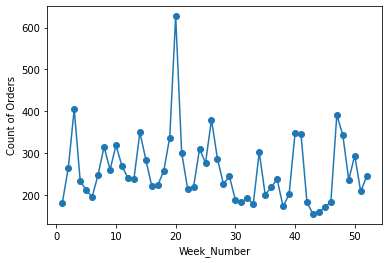

In [ ]:
#Plot the count of orders per week for the store.
data['Week_Number'] = data['date'].dt.week
data1 = data[data['date'] >= '2017-01-02'].groupby('Week_Number').size()
plt.plot(data1,marker='o')
plt.xlabel('Week_Number')
plt.ylabel('Count of Orders')
plt.show()

# (C)

---



In [ ]:
# Compute the mean order value for gender 0 and for gender 1.
data.groupby('gender').mean()['value']

gender
0    363.890006
1    350.708361
Name: value, dtype: float64

* From above, it appears that there was a slight difference in the means of order value between two gender groups. I will repeatedly re-sample our dataset (with replacement) and calculate mean order value for those samples. The variation in mean order value will give us an indication of how uncertain the differences are.





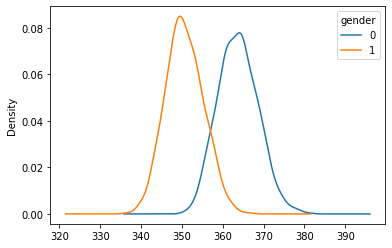

In [ ]:
# Creating an list with bootstrapped means for each AB-group
boot = []
for i in range(1000):
    boot_mean = data.sample(frac = 1,replace = True).groupby('gender')['value'].mean()
    boot.append(boot_mean)

boot = pd.DataFrame(boot)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot.plot(kind='density')

Probability that mean order value is greater when under gender group 0: 0.969


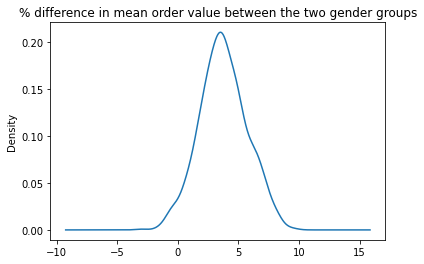

In [ ]:
# Add a column with the percentage difference between the two gender groups
boot['diff'] = (boot[0] - boot[1])/boot[1]*100

# Ploting the bootstrap % difference
ax = boot['diff'].plot(kind='density')
ax.set_title('% difference in mean order value between the two gender groups')

# Calculating the probability that mean order value is greater when under gender group 0
print('Probability that mean order value is greater when under gender group 0:',(boot['diff'] > 0).mean())

* More than 95% of the distribution is above 0%, in favor of gender group 0. The bootstrap result tells us that there is strong evidence that mean order value is higher when the gender group is 0 than when it is 1. Concluded the difference is significant





# (D)

---



* There are 8814 unique customers in total.
* From the confusion matrix, for gender group 1, there are 3512 true predictios, 895 false predicitions. 79.69% of gender 1 is predicted correctly
* From the confusion matrix, for gender group 0, there are 2189 true predictios, 2218 false predicitions. 49.67% of gender 0 is predicted correctly
* The predictions does a better job in gender 1 group. And the overall accuracy score is: 0.6468118901747221


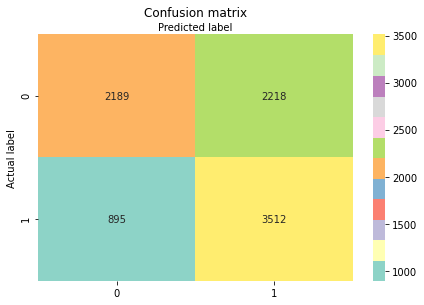

In [ ]:
def confusion_metric(y_test, y_pred):
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  cm = confusion_matrix(y_test,y_pred)
  fig, ax = plt.subplots()
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Set3" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  
confusion_metric(merge['gender'],merge['predicted_gender'])

from sklearn.metrics import accuracy_score

print('* There are',merge.shape[0],'unique customers in total.')
print('* From the confusion matrix, for gender group 1, there are 3512 true predictios, 895 false predicitions. \
79.69% of gender 1 is predicted correctly')
print('* From the confusion matrix, for gender group 0, there are 2189 true predictios, 2218 false predicitions.\
 49.67% of gender 0 is predicted correctly')
print('* The predictions does a better job in gender 1 group. And the overall accuracy score is:',accuracy_score(merge['gender'],merge['predicted_gender']))

# (E)

---



One of my favorite techniques is data visualization as it always empowers my data science presentations! As part of a final project of my business analytics course, my team had a month to finish our project and were required to deliver a 10 minute presentation on our project.Part of my role was to apply various models to predict customers final email-click decision. While our team were doing the mock presentation, I was told me my part which is explaining various models, are unclear and complicated to non-technical audience. So I decided to streamline my parts through incorporating graphs in order to make the algorithm easier to understand. For instance, I replaced the complicated mathematic formulas of Random Forest Algorithm within the decision tree graphs in the powerpoint. My team was pleased with my adjustment. While presenting, we received very positive feedbacks for effectively communicating complex knowledge. From there, I am constantly learning and expanding my skillset in data visualization!
